# Introduction
In this notebook, I have used data from [immtracker](https://myimmitracker.com/en/ca/trackers/consolidated-e-apr-tracker-express-entry-permanent-residency-application) and SS effectees tracking list (avalible from Whatsup group with same name) to compute some statstical measures of waiting time in security screening for permanent canadian residency.
This is mostly a fun project to see how much we can learn from sparse (from SS effectees list) and nosiy data (from immtracker) so use the results at your own risk. I have used a simple Bayesian model. After downloading the data (for immtracker I used myScraper.py and for SS effectees I copy/paste manually), I have created a prior distirbution using immtracker data (see below for details). Then I update the prior distribution using SS security list to obtain the posterior distribution. In the following, you can see some of the important statistics (e.g. expected waiting time, conditional expected waiting time) and model predictions (e.g. how many people in SS effectees list will get PPR this month?).
I will update the model from time to time (mostly update it with new data whenthey become avalible). However, eventually I will stop updating it so feel free to clone this notebook and use it for your own analysis.

# Download Data
The first step is to download the data. To download data from immtracker use myScraper.py and to download from SS effectees (or similar groups) join them. 

# Create the prior
immtracker is relatively big dataset (more than 8000 people as of this writing), however it is noisy and specially when applications takes longer than usual (e.g. security screening) people tends to forget about it and therefore most of the data belongs to people who got their PassPort Request (PPR) quickly. Moreover, most people don't fill the forms fully and therefore it is not possible to conclude when/(or if) their security screening (SS) started and therefore how long they waited from the start of SS to PPR (moreove, applications might take a long time for other reasons).
To avoid these problems, I only use profiles which we can detect the start of second backgorund checks (IP2) whcih potentially is the start of the SS. After that, I remove all profiles which are concluded in less than 150 days (SS most of the time takes way more than 150 days). I also add profiles with IP2 that are not concluded yet and age more than 150 days.
Since after all these filterings, number of selected PPRs would be small, I apply some tricks to compute probablity of PPR for every month. Basically the idea is in the limit the probablity of PPR for month i should be close to following:
A(i): number of none-PPR before month i
B(i): number of none-PPR afetr month i
P(i): probablity of PPR for month i
P(i) = A(i)/(A(i)+B(i))
So every none-PPR data point will be accounted as PPR with probablity of P(i) for month i. Any PPR profile will be counted as PPR with probablity of 1 for the month corresponding to PPR date.
Here is the code do all that:

Prior dists. [ 0.00068446  0.02806305  0.09396893  0.17988562  0.22879523  0.18607361
  0.11960739  0.0720181   0.03477732  0.02271458  0.01504017  0.00717941
  0.00352068  0.00192299  0.0012253   0.00092064  0.0007876   0.0007295
  0.00070413  0.00069305  0.00068821]


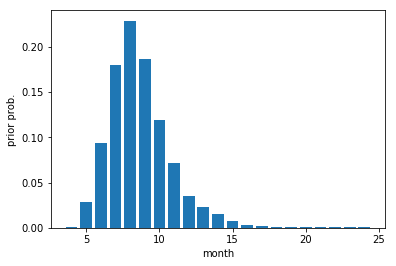

In [80]:
%matplotlib inline  

import json
import re
import datetime
import utils
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from dateutil.parser import parse


url_pat = re.compile(".*cases\/(.*)")

# downloaded using myScrapy.py
files = ["data/data_extracted-feb02-2018.json"]

# list for raw data
raw_data = list()
for f in files:
    raw_data.append(json.load(open(f)))

# patterns to search in raw data
raw_key_patterns = {"USER": "Username",
                    "APR-DATE": "e-APR AOR Date",
                    "BGS-LAST-STATUS": "BGS Last Change Status",
                    "BGS-LAST-DATE": "Last BGS change Date",
                    "PPR-DATE": "PPR Date",
                    "IP2-DATE": "Date Background check status is in: IP2",
                    "SECURITY-SCREENING-DATE": "Security Screening Start Date",
                    "STATE": "State",
                    "STREAM": "Stream",
                    "EAPR-PPR": "Days from e-APR to PPR"
                    }
DATES = ["APR-DATE", "BGS-LAST-DATE",
         "PPR-DATE", "IP2-DATE",
         "SECURITY-SCREENING-DATE"]

data = dict()
# loop over all data
# assume datasets are in time order (older first)
# we assume people eithe update or remove
# if remove we still have them from older snapshot.
for dataset in raw_data:
    for record in dataset:
        # creat a unique key based on URL
        m = url_pat.match(record["URL"])
        ukey = m.group(1)
        # dont inlcude removed cases.
        if "Removal date" not in record:
            # if this the first time we see this record.
            if ukey not in data:
                data[ukey] = dict()
            for key, val in raw_key_patterns.items():
                if key not in DATES:
                    data[ukey][key] = record[val]
                else:
                    if record[val] != "":
                        data[ukey][key] = datetime.datetime.strptime(record[val], '%d/%m/%Y')
                    elif key not in data[ukey]:
                        data[ukey][key] = None

# select only cases that spended at least 150s days after IP2
N =  datetime.timedelta(days=150)
# filter the data: just PPR that toke more than N days from IP2
# (or have specified SS date) and none-PPR who are waiting for more than N
# days since IP2 or have specific SS date.
filterd_data = dict()
for key, val in data.items():
    ip2 = None
    if val["SECURITY-SCREENING-DATE"] is not None:
        ip2 = val["SECURITY-SCREENING-DATE"]
    elif val["IP2-DATE"] is not None:
        ip2 = val["IP2-DATE"]
    elif (val["BGS-LAST-STATUS"] == "In Progress (2)" and
            val["BGS-LAST-DATE"] is not None):
        ip2 = val["BGS-LAST-DATE"]

    if val["PPR-DATE"] is not None:
        if ip2 is not None:
            delta = val["PPR-DATE"] - ip2
            # print(delta)
            if delta >= N:
                filterd_data[key] = data[key]
    elif val["STATE"] == "Active":
        if ip2 is not None:
            delta = datetime.datetime.now() - ip2
            if delta > N:
                filterd_data[key] = data[key]
    if key in filterd_data:
        if val["PPR-DATE"] is not None:
            delta = val["PPR-DATE"] - ip2
            filterd_data[key]["duration"] = delta.days
        else:
            delta = datetime.datetime.now() - ip2
            filterd_data[key]["duration"] = delta.days

# print(len(filterd_data))
        
# number of PPR with more than 150 days are too small
# we need to add non-PPR by distributing them on all forward dates

# minimum and maximum  number of month in SS
min_dur = 4 # 4 month
max_dur = 24

index = [x for x in range(min_dur, max_dur + 1)]

# flow based redistribution
flowin = {}
flowout = {}
for i in index:
    flowin[i] = 0.0
    flowout[i] = 100.0  # smoothing (100 psudocount)
    for key in filterd_data:
        if filterd_data[key]["PPR-DATE"] is not None:
            pass
        else:
            # we distribute data points not get their PRR to all
            # following months
            # approximate month by 30 days.
            ind = round(filterd_data[key]["duration"] / 30)
            if ind < i :
                flowin[i] += 1
            else:
                flowout[i] += 1
WW = {}
abs_ratio = {}
for i in index:
    # print(i, " abosrbed: ", flowin[i] / (flowin[i] + flowout[i]))
    # this is P(i)
    abs_ratio[i] = flowin[i] / (flowin[i] + flowout[i])
# WW is how data point i (none-PPR) is distributed in follwing month as PPR
for i in index:
    remain = 1.0
    WW[i] = dict()
    for j in index[i-min_dur:]:
        WW[i][j] = remain * abs_ratio[j]
        remain = remain * (1-abs_ratio[j])

# print(WW)
prior = .1 * np.ones(max_dur - min_dur + 1)
np_w = 1  # weght the none-ppr to balance it a little bit
for key in filterd_data:
    if filterd_data[key]["PPR-DATE"] is not None:
        # approximate month by 30 days.
        ind = round(filterd_data[key]["duration"] / 30)
        if ind < min_dur:
            ind = min_dur
        if ind > max_dur:
            ind = max_dur
        prior[ind - min_dur] += 1
    else:
        # we distribute data points not get their PRR to all
        # following months
        ind = round(filterd_data[key]["duration"] / 30)
        if ind < min_dur:
            ind = min_dur
        if ind > max_dur:
            ind = max_dur
        for i in range(ind, max_dur+1):
            prior[i-min_dur] += np_w * WW[ind][i]

# print(prior)
nprior = prior / np.sum(prior)

print("Prior dists.", nprior)

plt.bar(index, nprior)
plt.xlabel("month")
plt.ylabel("prior prob.")
plt.show()

# SS effectees Data
Now we look into data downloaded from SS effectees group. I have two set One data from 1st Jan )actually I collect it in 1st Feb but delete PPRs from Jan so it looks like 1st Jan) and 1st of Feb. First, I look into some stats from  Data downloaded in 1st Feb.
In the following we can see average PPR time for all cases finalized by 1st of Feb from group data. Also I computed a lower bound by considering the fact that minimum waiting time for none-PPR case is the current time they have been waiting.

In [81]:
# this date should match the  data file
analysis_date = "1 Feb 18"
lines = [line.strip() for line in open("data/ppr_track_feb.txt")]

mm = re.compile("(.*)((Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d+-\d+).*((Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d+-\d+).*")
mm2 = re.compile("(.*)((Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d+-\d+).*((Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d+-\d+).*((Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d+-\d+).*")
mm3 = re.compile(".*\((.*)\).*")
SS_GROUP = {}
for line in lines:
    # for dateutil
    line = line.replace(",", "-")
    t = mm2.match(line)
    if (t == None):
        t = mm.match(line)
    #print(line)
    key = t.group(1)
    aor = parse(t.group(2))
    ss = parse(t.group(4))
    try:
        pprd = parse(t.group(6))
     #   print(t.group(6))
    except:
        pprd = None
    t2 = mm3.match(t.group(1))
    try:
        stream = t2.group(1)
    except:
        stream = "FSWO"
    if pprd is not None:
        delta = pprd - ss
    else:
        # delta = datetime.datetime.now() - ss
        delta = datetime.datetime.strptime(analysis_date, "%d %b %y") - ss
        # test for jan
        #delta = datetime.datetime.strptime("1 Jan 18", "%d %b %y") - ss
    SS_GROUP[key] = {"AOR-DATE": aor, "IP2-DATE": ss, "PPR-DATE": pprd, "STREAM": stream, "duration": delta.days}
    
ppr_avg = 0.0
ppr_count = 0.0
all_avg = 0.0
all_count = 0.0
fswo_ppr_avg = 0.0
fswo_ppr_count = 0.0
fswo_all_avg = 0.0
fswo_all_count = 0.0
for key, val in SS_GROUP.items():
    all_avg += val["duration"]
    all_count += 1
    if val["PPR-DATE"] is not None:
        ppr_avg += val["duration"]
        ppr_count += 1
    if val["STREAM"] == "FSWO":
        fswo_all_count += 1
        fswo_all_avg += val["duration"]
        if val["PPR-DATE"] is not None:
            fswo_ppr_count += 1
            fswo_ppr_avg += val["duration"]

ppr_avg = ppr_avg / ppr_count
all_avg = all_avg / all_count
fswo_ppr_avg = fswo_ppr_avg / fswo_ppr_count
fswo_all_avg = fswo_all_avg / fswo_all_count

print("ppr_count(ss group) ", ppr_count, " ppr_avg(ss group): ", ppr_avg / 30.0, " months")
print("ppr_avg_lower_bound (ss group):", all_avg / 30.0," months")

ppr_count(ss group)  27.0  ppr_avg(ss group):  8.25679012345679  months
ppr_avg_lower_bound (ss group): 8.136197916666667  months


# FSWO vs. others
One question is if there is a difference based on streams?  The answers, seems to be YES. Here is the average for FSWO (compare it for average for all above).

In [82]:
print("fswo_ppr_avg_lower_bound:", fswo_all_avg / 30.0, " months")

fswo_ppr_avg_lower_bound: 7.163690476190476  months


# Final Model
Now we can compute the posterior distiribution by combining prior and SS data. Notice the expected (average) wait time in SS.

post. dist. [ 0.00068446  0.02806305  0.09396893  0.17988562  0.22879523  0.18607361
  0.11960739  0.0720181   0.03477732  0.02271458  0.01504017  0.00717941
  0.00352068  0.00192299  0.0012253   0.00092064  0.0007876   0.0007295
  0.00070413  0.00069305  0.00068821]


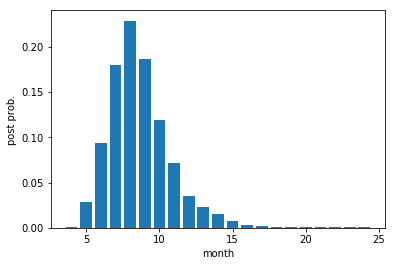

Expected number of month to stay in SS: 8.69782347543


In [83]:
import copy
post = copy.deepcopy(prior)

for key in SS_GROUP:
    if SS_GROUP[key]["PPR-DATE"] is not None:
        # approximate month by 30 days.
        ind = round(SS_GROUP[key]["duration"] / 30)
        if ind < min_dur:
            ind = min_dur
        if ind > max_dur:
            ind = max_dur
        post[ind - min_dur] = prior[ind - min_dur]

# print(post)
npost = post / np.sum(post)
print("post. dist.", npost)
plt.bar(index, npost)
plt.xlabel("month")
plt.ylabel("post prob.")
plt.show()

print("Expected number of month to stay in SS:", np.sum(index*npost))

# Conditioanl Dist.
Now it is not the end of story. What if you have already waited in SS for 10 month? What is your "Expected" number of month and how many more month on the average you should wait? 
Here I computed the conditional distributions. However, notice the numbers are less relabile for the tail of the distribution (e.g. if you already waited 12 month in SS  then the predictions are not as good for you) due to data sparsity. To make it easier I created a table that shows what is the probablity of getting your PPR given you have already waited N month in SS. 

In [87]:
import pandas as pd
from IPython.display import display, HTML
st = 4
en = 16
mean_cond = dict()
npost_cond = dict()
for i in range(st, en+1):
    k = i - min_dur
    npost2 = post[k:] / np.sum(post[k:])
    # print(k+min_dur, " 2p*   ", npost2)
    # print(np.sum(index[k:]*npost2))
    npost_cond[i] = 100 * npost2
    mean_cond[i] = np.sum(index[k:]*npost2)

table1 = np.zeros((en-st+1, 15))
for key  in npost_cond:
    temp = 0 * np.ones(15)
    if len(npost_cond[key]) > len(temp):
        temp = npost_cond[key][0:15]
    else:
        temp[0:len(npost_cond[key])] = npost_cond[key]
    
    table1[key-st,:] = temp
pd.options.display.float_format = '{:,.1f}'.format
print("Each row show the probablity of getting after N month (so 0 mean this month)")
print("First number of each row is the number of month passed from SS start.")
# print(pd.DataFrame(table1, index=range(st, en+1), columns=range(0,15)))

display(HTML(pd.DataFrame(table1, index=range(st, en+1), columns=range(0,15)).to_html()))


table2 = np.zeros((en-st+1,1))
for key in mean_cond:
    table2[key-st] = mean_cond[key]

display(HTML(pd.DataFrame(table2, index=range(st, en+1), columns=["Expected month in SS"]).to_html()))

Each row show the probablity of getting after N month (so 0 mean this month)
First number of each row is the number of month passed from SS start.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
4,0.1,2.8,9.4,18.0,22.9,18.6,12.0,7.2,3.5,2.3,1.5,0.7,0.4,0.2,0.1
5,2.8,9.4,18.0,22.9,18.6,12.0,7.2,3.5,2.3,1.5,0.7,0.4,0.2,0.1,0.1
6,9.7,18.5,23.6,19.2,12.3,7.4,3.6,2.3,1.5,0.7,0.4,0.2,0.1,0.1,0.1
7,20.5,26.1,21.2,13.6,8.2,4.0,2.6,1.7,0.8,0.4,0.2,0.1,0.1,0.1,0.1
8,32.8,26.7,17.2,10.3,5.0,3.3,2.2,1.0,0.5,0.3,0.2,0.1,0.1,0.1,0.1
9,39.7,25.5,15.4,7.4,4.8,3.2,1.5,0.8,0.4,0.3,0.2,0.2,0.2,0.2,0.1
10,42.3,25.5,12.3,8.0,5.3,2.5,1.2,0.7,0.4,0.3,0.3,0.3,0.2,0.2,0.2
11,44.2,21.3,13.9,9.2,4.4,2.2,1.2,0.8,0.6,0.5,0.4,0.4,0.4,0.4,0.0
12,38.3,25.0,16.5,7.9,3.9,2.1,1.3,1.0,0.9,0.8,0.8,0.8,0.8,0.0,0.0
13,40.5,26.8,12.8,6.3,3.4,2.2,1.6,1.4,1.3,1.3,1.2,1.2,0.0,0.0,0.0


,Expected month in SS
4,8.7
5,8.7
6,8.8
7,9.1
8,9.7
9,10.5
10,11.4
11,12.5
12,13.6
13,14.6


# Predictions
OK in this section, I check for model accuracy by comparing its predictions vs. reality. So far I only test for Jan but will add more rows in next few months. 
Model prediction for Jan was xxx